# RXID : Pill Identifier 
## Using TFlearn to design a ConvNet that detects Pill Shapes

## Connect to Google Drive

Training Data is hosted there

In [1]:
# !python -m pip install tqdm
# !python -m pip install tensorflow
# !python -m pip install tflearn
# !pip install --upgrade numpy
from google.colab import drive
gdrive_dir = '/content/gdrive' 
drive.mount(gdrive_dir)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports and Parameters

In [0]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage of progress bar for tasks.

In [0]:
#_____________   Init Vars ______________________
TRAIN_DIR = '/content/gdrive/My Drive/csv/train'
TEST_DIR = '/content/gdrive/My Drive/csv/test'
SAVE_DIR = '/content/gdrive/My Drive/csv'
IMG_SIZE = 100   # Image size = 100 x 100
LR = 1e-5        # Learning Rate = .000001
num_epochs = 5   # number of epochs
class_types = 2  # number of classification types
if class_types < 2:
  loss_function = 'binary_crossentropy'
else:
  loss_function = 'categorical_crossentropy'

# just so we remember which saved model is which, sizes must match
MODEL_NAME = 'CapRndOval-{}-{}.model'.format(LR, '2conv-basic') 

## Create + Shuffle Training & Test Images

In [0]:
# ____ label the image ____
'''    based on 1st 3 letters of filename
       rnd, cap, or ovl  must be used to identify the shape 
       in the filename ____'''

def label_img(img):
    word_label = img.split('.')[-3]  
    # ____ Conversion to one-hot array _____________________    
    if class_types < 3:
        # __ ___ Binary classification_____     [rnd,cap]     
        if   word_label == 'rnd': return [1,0]  # [1, 0]
        elif word_label == 'cap': return [0,1]  # [0, 1]
    else:
        # __ Multivariate classification____      [rnd,cap,ovl]     
        if   word_label == 'rnd': return [1,0,0]  # [1, 0, 0]
        elif word_label == 'cap': return [0,1,0]  # [0, 1, 0]
        elif word_label == 'ovl': return [0,0,1]  # [0, 0, 1]

# ____ create list of numpy arrays based on resized images ____
def process_data(image_dir, save_filename):
    image_list = []
    ctr = 0
    for img in tqdm(os.listdir(image_dir)):
        # ___only image files____
        if ('.jpg' in str(img)) or ('.png' in str(img)):
            label = label_img(img)
            path = os.path.join(image_dir,img)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            image_list.append([np.array(img),np.array(label)])
            ctr += 1
    if ctr == 0:
        print('Warning NO images were found. Verify correct file location')
    else:
        print(f'{ctr} images labeled')
        # ___ shuffle the list ____
        shuffle(image_list)
        print(f'{ctr} images from {image_dir} have been labeled & shuffled')
        #  ___ save the image data to a np file ___
        np.save(save_filename, image_list)
        print(f'Image data saved to file:{save_filename}')
    return image_list

In [5]:
#  Create train and test data sets
train_data = process_data(TRAIN_DIR, SAVE_DIR+'/train_data.npy')

test_data  = process_data(TEST_DIR, SAVE_DIR+'/test_data.npy')

100%|██████████| 3001/3001 [00:12<00:00, 236.53it/s]


3000 images labeled
3000 images from /content/gdrive/My Drive/csv/train have been labeled & shuffled


  3%|▎         | 27/1001 [00:00<00:03, 254.65it/s]

Image data saved to file:/content/gdrive/My Drive/csv/train_data.npy


100%|██████████| 1001/1001 [00:03<00:00, 278.79it/s]


1000 images labeled
1000 images from /content/gdrive/My Drive/csv/test have been labeled & shuffled
Image data saved to file:/content/gdrive/My Drive/csv/test_data.npy


## Create a ConvNet model with 6 layers

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, class_types, activation='softmax')   # class_types is the number of classification types we are predicting
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss=loss_function, name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='/log')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [0]:
# We want to be saving our model after every session and reloading it if we have a saved version
# if os.path.exists('{}.meta'.format(MODEL_NAME)):
#     model.load(MODEL_NAME)
#     print('model loaded!')

In [0]:
# Grabbing some of the train data for validation
train = train_data[:-200]
validation = train_data[-200:]

#  Create Train X / Y
# NOTE!!! --->> array[:,0] and array[:,1] did NOT work <---
# HERE! Separating features and labels:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]


# Create Validation X/ Y  For validation set:
val_x = np.array([i[0] for i in validation]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
val_y = [i[1] for i in validation]

## Training the Model

In [9]:
model.fit({'input': X}, {'targets': Y}, n_epoch=num_epochs, validation_set=({'input': val_x}, {'targets': val_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 219  | total loss: 0.45621 | time: 0.667s
| Adam | epoch: 005 | loss: 0.45621 - acc: 0.8881 -- iter: 2752/2800
Training Step: 220  | total loss: 0.45470 | time: 1.685s
| Adam | epoch: 005 | loss: 0.45470 - acc: 0.8899 | val_loss: 0.42622 - val_acc: 0.9050 -- iter: 2800/2800
--


## Saving Trained Model for later use

In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:/content/CapRndOval-1e-05-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [0]:
# from tutorial
# https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
# !tensorboard --logdir=content/log

## Test data

In [0]:
# if you need to create the data:
#     test_data = process_test_data()
# if you already have some saved:
#     test_data = np.load('test_data.npy')

In [0]:
# NOTE!!! --->> array[:,0] and array[:,1] did NOT work <---
# HERE! Separating features and labels:
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test_data]

## Predicting with Test data

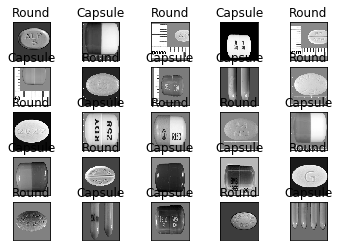

In [14]:
import matplotlib.pyplot as plt

fig=plt.figure()

for indx, data in enumerate(test_data[-25:]):
    img_nparray = data[1]
    img_data    = data[0]
    
    y = fig.add_subplot(5,5,indx+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]

    if   np.argmax(model_out) == 0: str_label='Round'
    elif np.argmax(model_out) == 1: str_label='Capsule'
    elif np.argmax(model_out) == 2: str_label='Oval'
    else: str_label='Unknown'
    plt.title(str_label)
      
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    y.imshow(orig,cmap='gray')
plt.show()

In [0]:
predictions = model.predict(test_x)

In [19]:
import pandas as pd

# Add descriptive labels to actuals(test_y) & predictions 
pred_label = []
for prediction in predictions:
    if   np.argmax(prediction) == 0: prediction='Round'
    elif np.argmax(prediction) == 1: prediction='Capsule'
    elif np.argmax(prediction) == 2: prediction='Oval'
    else: prediction='Unknown'
    pred_label.append(prediction)
test_label= []
for label in test_y:
    if   np.argmax(label) == 0: label='Round'
    elif np.argmax(label) == 1: label='Capsule'
    elif np.argmax(label) == 2: label='Oval'
    else: label='Unknown'
    test_label.append(label)    

#  Setup a dataframe of prediction results
df = pd.DataFrame(list(zip(test_label, pred_label)), 
                  columns =['Real', 'Prediction'])

#  Add an Accuracy Column
def accuracy_col(row):
    if row['Real'] == row['Prediction'] :
        return 1
    else:
        return 0
df['Accuracy'] = df.apply(lambda row: accuracy_col(row), axis=1)    

#  Print Result Summary
df.Accuracy.value_counts()
print(f'{df.Accuracy.value_counts()[1]} correct and {df.Accuracy.value_counts()[0]} incorrect predictions made\n')
print(f'Accuracy : {round(df.Accuracy.value_counts()[1]/len(df)*100,2)}%\n')
df.head(1000)


901 correct and 99 incorrect predictions made

Accuracy : 90.1%



,Real,Prediction,Accuracy
0,Capsule,Round,0
1,Capsule,Capsule,1
2,Round,Round,1
3,Capsule,Capsule,1
4,Round,Capsule,0
5,Capsule,Capsule,1
6,Capsule,Round,0
7,Round,Round,1
8,Round,Round,1
9,Round,Round,1
